In [1]:
import os
import datetime

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


# **1、准备数据**

titanic数据集的目标是根据乘客信息预测他们在Titanic号撞击冰山沉没后能否生存。

结构化数据一般会使用Pandas中的DataFrame进行预处理。



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader,TensorDataset

dftrain_raw = pd.read_csv('../data/titanic/train.csv')
dftest_raw = pd.read_csv('../data/titanic/test.csv')
dftrain_raw.head(5)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S


字段说明：

- Survived:0代表死亡，1代表存活【y标签】
- Pclass:乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】
- Name:乘客姓名 【舍去】
- Sex:乘客性别 【转换成bool特征】
- Age:乘客年龄(有缺失) 【数值特征，添加“年龄是否缺失”作为辅助特征】
- SibSp:乘客兄弟姐妹/配偶的个数(整数值) 【数值特征】
- Parch:乘客父母/孩子的个数(整数值)【数值特征】
- Ticket:票号(字符串)【舍去】
- Fare:乘客所持票的价格(浮点数，0-500不等) 【数值特征】
- Cabin:乘客所在船舱(有缺失) 【添加“所在船舱是否缺失”作为辅助特征】
- Embarked:乘客登船港口:S、C、Q(有缺失)【转换成onehot编码，四维度 S,C,Q,nan】

利用Pandas的数据可视化功能我们可以简单地进行探索性数据分析EDA（Exploratory Data Analysis）。
### label分布情况


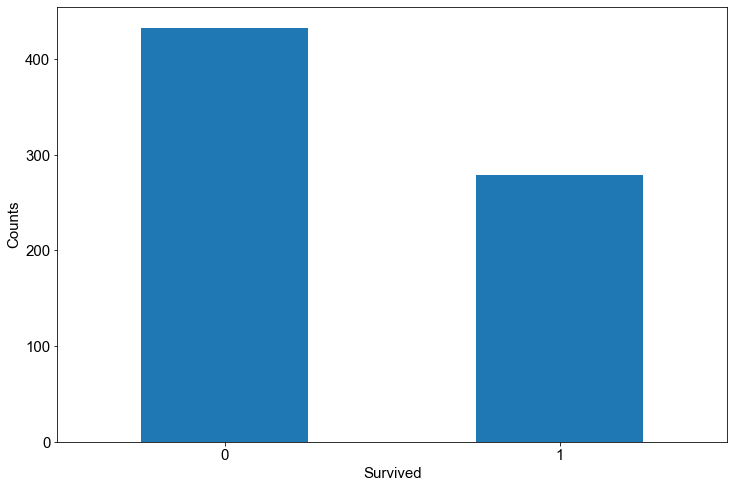

In [3]:
ax = dftrain_raw['Survived'].value_counts().plot(kind = 'bar',
     figsize = (12,8),fontsize=15,rot = 0)
ax.set_ylabel('Counts',fontsize = 15)
ax.set_xlabel('Survived',fontsize = 15)
plt.show()

### 年龄分布情况

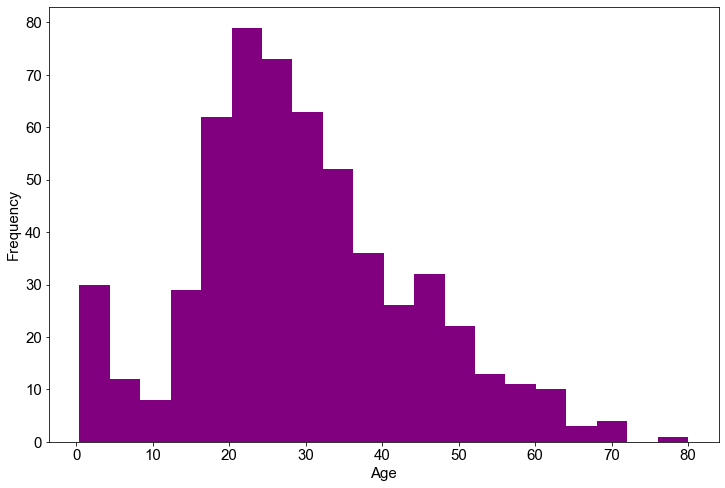

In [4]:
ax = dftrain_raw['Age'].plot(kind = 'hist',bins = 20,color= 'purple',
                    figsize = (12,8),fontsize=15)

ax.set_ylabel('Frequency',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()


### 年龄和label的相关性


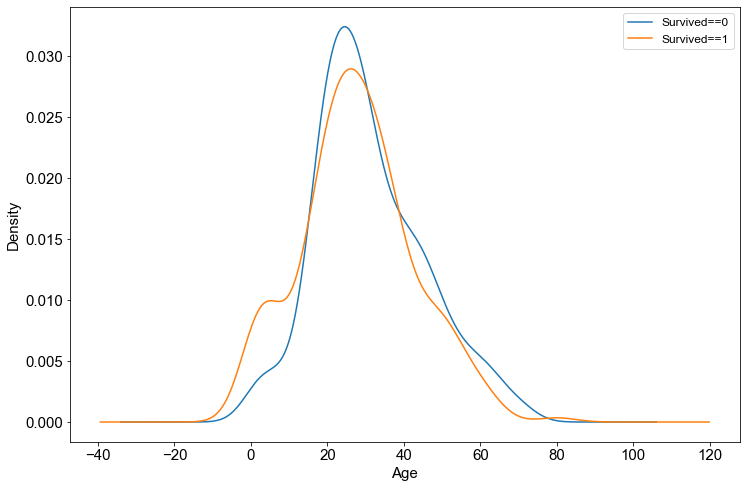

In [5]:
ax = dftrain_raw.query('Survived == 0')['Age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
dftrain_raw.query('Survived == 1')['Age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
ax.legend(['Survived==0','Survived==1'],fontsize = 12)
ax.set_ylabel('Density',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

### 数据预处理

In [6]:
def preprocessing(dfdata):

    dfresult= pd.DataFrame()

    #Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass_' +str(x) for x in dfPclass.columns ]
    dfresult = pd.concat([dfresult,dfPclass],axis = 1)

    #Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult,dfSex],axis = 1)

    #Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')

    #SibSp,Parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']

    #Carbin
    dfresult['Cabin_null'] =  pd.isna(dfdata['Cabin']).astype('int32')

    #Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'],dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult,dfEmbarked],axis = 1)

    return(dfresult)

x_train = preprocessing(dftrain_raw).values
y_train = dftrain_raw[['Survived']].values

x_test = preprocessing(dftest_raw).values
y_test = dftest_raw[['Survived']].values

print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )

print("y_train.shape =", y_train.shape )
print("y_test.shape =", y_test.shape )


x_train.shape = (712, 15)
x_test.shape = (179, 15)
y_train.shape = (712, 1)
y_test.shape = (179, 1)


进一步使用DataLoader和TensorDataset封装成可以迭代的数据管道:



In [7]:
dl_train = DataLoader(TensorDataset(torch.tensor(x_train).float(),torch.tensor(y_train).float()),
                     shuffle = True, batch_size = 8)
dl_valid = DataLoader(TensorDataset(torch.tensor(x_test).float(),torch.tensor(y_test).float()),
                     shuffle = False, batch_size = 8)

查看训练数据管道:

In [8]:
for features,labels in dl_train:
    print(features,labels)
    break

tensor([[  1.0000,   0.0000,   0.0000,   1.0000,   0.0000,  23.0000,   0.0000,
           1.0000,   0.0000, 113.2750,   0.0000,   1.0000,   0.0000,   0.0000,
           0.0000],
        [  0.0000,   0.0000,   1.0000,   1.0000,   0.0000,  17.0000,   0.0000,
           0.0000,   0.0000,  14.4583,   1.0000,   1.0000,   0.0000,   0.0000,
           0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000,   1.0000,  22.0000,   0.0000,
           0.0000,   0.0000,   9.0000,   1.0000,   0.0000,   0.0000,   1.0000,
           0.0000],
        [  1.0000,   0.0000,   0.0000,   1.0000,   0.0000,  36.0000,   0.0000,
           0.0000,   2.0000,  71.0000,   0.0000,   0.0000,   0.0000,   1.0000,
           0.0000],
        [  1.0000,   0.0000,   0.0000,   0.0000,   1.0000,  23.0000,   0.0000,
           0.0000,   1.0000,  63.3583,   0.0000,   1.0000,   0.0000,   0.0000,
           0.0000],
        [  0.0000,   0.0000,   1.0000,   1.0000,   0.0000,   0.0000,   1.0000,
           1.0000,   0.0000,  1

# 2、定义模型

使用Pytorch通常有3种方式构建模型：

- nn.Sequential按层顺序构建模型
- 继承nn.Module基类构建自定义模型
- 继承nn.Module基类构建模型并辅助应用模型容器进行封装

这里选择最简单的nn.Sequential 按层顺序模型


In [9]:
def create_net():
    net = nn.Sequential()
    net.add_module("linear1", nn.Linear(15, 20))
    net.add_module("relu1", nn.ReLU())
    net.add_module("linear2", nn.Linear(20, 15))
    net.add_module("relu2", nn.ReLU())
    net.add_module("linear3", nn.Linear(15, 1))
    net.add_module("sigmoid", nn.Sigmoid())
    return net

net = create_net()
print(net)

Sequential(
  (linear1): Linear(in_features=15, out_features=20, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=20, out_features=15, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=15, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


使用torchkeras.summary预览模型结构:


In [10]:
from torchkeras import summary
summary(net, input_shape=(15,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]             320
              ReLU-2                   [-1, 20]               0
            Linear-3                   [-1, 15]             315
              ReLU-4                   [-1, 15]               0
            Linear-5                    [-1, 1]              16
           Sigmoid-6                    [-1, 1]               0
Total params: 651
Trainable params: 651
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000057
Forward/backward pass size (MB): 0.000549
Params size (MB): 0.002483
Estimated Total Size (MB): 0.003090
----------------------------------------------------------------


# 3、训练模型

Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异：

- 脚本形式训练循环
- 函数形式训练循环
- 类形式训练循环

此处使用脚本形式：



In [11]:
from sklearn.metrics import accuracy_score

loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.01)

def metric_func(y_pred, y_true):
    y_true = y_true.data.numpy()
    y_pred = y_pred.data.numpy()
    return accuracy_score(y_true, y_pred > 0.5)

metric_name = "accuracy"

In [12]:
epochs = 10
log_step_freq = 30

# 创建一个只有列名的空df
dfhistory = pd.DataFrame(columns = ["epoch","loss",metric_name,"val_loss","val_"+metric_name])

print("Start training...")
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("==="*4 + nowtime + "==="*4)

for epoch in range(1, epochs+1):
    # 1. 训练循环
    net.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1

    for step, (features, labels) in enumerate(dl_train, 1):
        # 梯度清零
        optimizer.zero_grad()

        # 正向传播求损失
        predictions = net(features)
        loss = loss_func(predictions, labels)
        metric = metric_func(predictions, labels)

        # 反向传播求梯度
        loss.backward()
        optimizer.step()

        # 打印batch级别的日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step % log_step_freq == 0:
            print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                  (step, loss_sum/step, metric_sum/step))
    # 2.验证循环
    net.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1

    for val_step, (features, labels) in enumerate(dl_valid, 1):
        # 关闭梯度计算
        with torch.no_grad():
            predictions = net(features)
            val_loss = loss_func(predictions, labels)
            val_metric = metric_func(predictions, labels)
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()

    # 3.记录日志
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch - 1] = info

    # 打印epoch级别日志
    print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
          "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f")
          %info)
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"==="*4 + "%s"%nowtime+"==="*4)

print("Finished Training...")

Start training...
============2021-04-26 11:29:34============
[step = 30] loss: 0.667, accuracy: 0.579
[step = 60] loss: 0.655, accuracy: 0.646

EPOCH = 1, loss = 0.638,accuracy  = 0.653, val_loss = 0.535, val_accuracy = 0.757

============2021-04-26 11:29:34============
[step = 30] loss: 0.599, accuracy: 0.662
[step = 60] loss: 0.596, accuracy: 0.683

EPOCH = 2, loss = 0.578,accuracy  = 0.697, val_loss = 0.476, val_accuracy = 0.741

============2021-04-26 11:29:34============
[step = 30] loss: 0.538, accuracy: 0.762
[step = 60] loss: 0.523, accuracy: 0.765

EPOCH = 3, loss = 0.536,accuracy  = 0.754, val_loss = 0.514, val_accuracy = 0.752

============2021-04-26 11:29:34============
[step = 30] loss: 0.551, accuracy: 0.746
[step = 60] loss: 0.530, accuracy: 0.771

EPOCH = 4, loss = 0.526,accuracy  = 0.763, val_loss = 0.478, val_accuracy = 0.788

============2021-04-26 11:29:34============
[step = 30] loss: 0.501, accuracy: 0.779
[step = 60] loss: 0.501, accuracy: 0.783

EPOCH = 5, loss

# 4、评估模型

我们首先评估一下模型在训练集和验证集上的效果

In [13]:
dfhistory

,epoch,loss,accuracy,val_loss,val_accuracy
0,1.0,0.637985,0.653090,0.535466,0.757246
1,2.0,0.577515,0.696629,0.476170,0.740942
2,3.0,0.536238,0.754213,0.514096,0.751812
3,4.0,0.526425,0.762640,0.477575,0.788043
4,5.0,0.495486,0.778090,0.431991,0.793478
5,6.0,0.506387,0.765449,0.460572,0.809783
6,7.0,0.471402,0.794944,0.454713,0.820652
7,8.0,0.470126,0.793539,0.421411,0.809783
8,9.0,0.452216,0.801966,0.432223,0.777174
9,10.0,0.446812,0.796348,0.432537,0.793478


In [14]:
import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

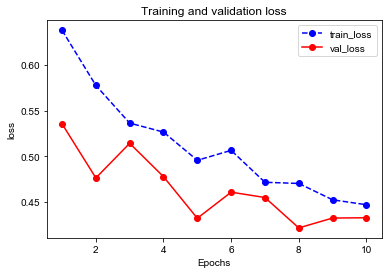

In [15]:
plot_metric(dfhistory, "loss")

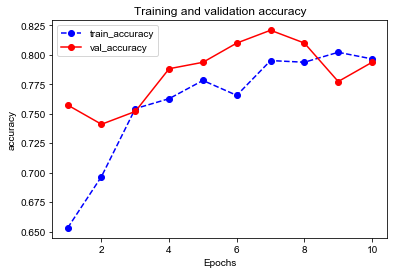

In [16]:
plot_metric(dfhistory, "accuracy")

# 5、使用模型进行预测


In [17]:
# 预测概率
y_pred_probs = net(torch.tensor(x_test[0:10]).float()).data
y_pred_probs

tensor([[0.1253],
        [0.6320],
        [0.3887],
        [0.4484],
        [0.5530],
        [0.9093],
        [0.0604],
        [0.8389],
        [0.4637],
        [0.1240]])

In [18]:
# 预测类别
y_pred = torch.where(y_pred_probs > 0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))
y_pred

tensor([[0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.]])

# 6、保存模型

Pytorch有两种保存模型的方式，都是通过调用pickle序列化方法实现：

- 第一种方法只保存模型参数
- 第二种方法保存完成模型

推荐使用第一种，第二种方法可能在切换设备和目录时出现各种问题

### 1、保存模型参数(推荐)



In [19]:
print(net.state_dict().keys())

odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias', 'linear3.weight', 'linear3.bias'])


In [20]:
# 保存模型参数：
torch.save(net.state_dict(), "../data/net_parameter.pkl")
net_clone = create_net()
net_clone.load_state_dict(torch.load("../data/net_parameter.pkl"))
net_clone.forward(torch.tensor(x_test[0:10]).float()).data

tensor([[0.1253],
        [0.6320],
        [0.3887],
        [0.4484],
        [0.5530],
        [0.9093],
        [0.0604],
        [0.8389],
        [0.4637],
        [0.1240]])

### 2、保存完整模型(不推荐)

In [21]:
torch.save(net, "../data/net_model.pkl")
net_loaded = torch.load("../data/net_model.pkl")
net_loaded(torch.tensor(x_test[0:10]).float()).data

tensor([[0.1253],
        [0.6320],
        [0.3887],
        [0.4484],
        [0.5530],
        [0.9093],
        [0.0604],
        [0.8389],
        [0.4637],
        [0.1240]])